# Diabetes - Group 06
Di Mauro Enrico Maria 0622701706 - Cuzzocrea Allegra 0622701707

## Prerequisites

- Upgrade pip, then restart the kernel and run again (the warning will disappear)

In [1]:
!pip install --upgrade pip

Defaulting to user installation because normal site-packages is not writeable


- Install requirements, then restart the kernel again (dependencies warnings can be ignored)

In [2]:
!pip install --user -r requirements.txt

- Import libraries

In [3]:
from matplotlib import pyplot as plt
from numpy import concatenate, save
from numpy.random import seed
from os import environ, makedirs, path, scandir
environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from pandas import DataFrame, read_csv
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow import keras
from tensorflow.random import set_seed

## Pipeline

### Parameters

In [4]:
units = 60
epochs = 30
batch_size = 128

### Components

In [5]:
'''
This function creates the path in which to save a plot (plots are shown), a numpy array or a model and saves that file
'''
def save_file(dir_path, file_name, file = None):
    if not path.exists(dir_path):
        makedirs(dir_path)
    if file is None:
        plt.savefig(path.join(dir_path, file_name), dpi = 300, bbox_inches = 'tight')
        plt.show()
    elif file_name.split('.')[-1] == 'h5':
        keras.models.save_model(file, path.join(dir_path, file_name))
    elif file_name.split('.')[-1] == 'npy':
        save(path.join(dir_path, file_name), file)

In [6]:
'''
This function takes in input the reference values and the prediction values as lists, returns a list with each index corresponding to the total number
of points within that zone (0=A, 1=B, 2=C, 3=D, 4=E) and creates the plot of clarke_error_grid
'''
def clarke_error_grid(ref_values, pred_values, title_string):
    #Check to see if the lengths of the reference and prediction arrays are the same
    assert (len(ref_values) == len(pred_values)), 'Unequal number of values (reference : {}) (prediction : {}).'.format(len(ref_values), len(pred_values))

    #Check to see if the values are within the normal physiological range, otherwise it gives a warning
    if max(ref_values) > 400 or max(pred_values) > 400:
        print('Input Warning: the maximum reference value {} or the maximum prediction value {} exceeds the normal physiological range of glucose (<400 mg/dl).'.format(max(ref_values), max(pred_values)))
    if min(ref_values) < 0 or min(pred_values) < 0:
        print('Input Warning: the minimum reference value {} or the minimum prediction value {} is less than 0 mg/dl.'.format(min(ref_values),  min(pred_values)))

    #Clear plot
    plt.clf()
    plt.figure(figsize=(6, 6))
    
    #Set up plot
    plt.scatter(ref_values, pred_values, marker='o', color='black', s=8)
    plt.title(title_string)
    plt.xlabel('Reference Concentration (mg/dl)')
    plt.ylabel('Prediction Concentration (mg/dl)')
    plt.xticks([0, 50, 100, 150, 200, 250, 300, 350, 400])
    plt.yticks([0, 50, 100, 150, 200, 250, 300, 350, 400])
    plt.gca().set_facecolor('white')

    #Set axes lengths
    plt.gca().set_xlim([0, 400])
    plt.gca().set_ylim([0, 400])
    plt.gca().set_aspect((400)/(400))

    #Plot zone lines
    plt.plot([0,400], [0,400], ':', c='black')                      #Theoretical 45 regression line
    plt.plot([0, 175/3], [70, 70], '-', c='black')
    plt.plot([175/3, 400/1.2], [70, 400], '-', c='black')           #Replace 320 with 400/1.2 because 100*(400 - 400/1.2)/(400/1.2) =  20% error
    plt.plot([70, 70], [84, 400],'-', c='black')
    plt.plot([0, 70], [180, 180], '-', c='black')
    plt.plot([70, 290],[180, 400],'-', c='black')
    plt.plot([70, 70], [0, 56], '-', c='black')                     #Replace 175.3 with 56 because 100*abs(56-70)/70) = 20% error
    plt.plot([70, 400], [56, 320],'-', c='black')
    plt.plot([180, 180], [0, 70], '-', c='black')
    plt.plot([180, 400], [70, 70], '-', c='black')
    plt.plot([240, 240], [70, 180],'-', c='black')
    plt.plot([240, 400], [180, 180], '-', c='black')
    plt.plot([130, 180], [0, 70], '-', c='black')

    #Add zones titles
    plt.text(30, 15, 'A', fontsize=15)
    plt.text(370, 260, 'B', fontsize=15)
    plt.text(280, 370, 'B', fontsize=15)
    plt.text(160, 370, 'C', fontsize=15)
    plt.text(160, 15, 'C', fontsize=15)
    plt.text(30, 140, 'D', fontsize=15)
    plt.text(370, 120, 'D', fontsize=15)
    plt.text(30, 370, 'E', fontsize=15)
    plt.text(370, 15, 'E', fontsize=15)

    #Statistics from the data
    zones = [0] * 5
    for i in range(len(ref_values)):
        if (ref_values[i] <= 70 and pred_values[i] <= 70) or (pred_values[i] <= 1.2*ref_values[i] and pred_values[i] >= 0.8*ref_values[i]):
            zones[0] += 1    #Zone A

        elif (ref_values[i] >= 180 and pred_values[i] <= 70) or (ref_values[i] <= 70 and pred_values[i] >= 180):
            zones[4] += 1    #Zone E

        elif ((ref_values[i] >= 70 and ref_values[i] <= 290) and pred_values[i] >= ref_values[i] + 110) or ((ref_values[i] >= 130 and ref_values[i] <= 180) and (pred_values[i] <= (7/5)*ref_values[i] - 182)):
            zones[2] += 1    #Zone C
        elif (ref_values[i] >= 240 and (pred_values[i] >= 70 and pred_values[i] <= 180)) or (ref_values[i] <= 175/3 and pred_values[i] <= 180 and pred_values[i] >= 70) or ((ref_values[i] >= 175/3 and ref_values[i] <= 70) and pred_values[i] >= (6/5)*ref_values[i]):
            zones[3] += 1    #Zone D
        else:
            zones[1] += 1    #Zone B
    zones = [zone/len(ref_values) for zone in zones]
    
    return zones

In [7]:
'''
This function creates the data history of a patient (glucose, insulin, carbohydrates) and a plot of that history
'''
def data_history(dataset, title_string):
    G = []
    I = []
    C = []
    values = dataset.values.astype('float32')
    
    for column in range(len(dataset.columns) - 1):
        module = column % 3
        if module == 0:
            G.extend(values[:, column])
        elif module == 1:
            I.extend(values[:, column])
        else:
            C.extend(values[:, column])

    plt.clf()
    plt.figure(figsize=(64, 9))
    
    plt.title(title_string)
    
    plt.subplot(3, 1, 1)
    plt.ylabel('Glucose')
    plt.plot(G, alpha = 0.5, lw = 1, label = 'G(t)')
    plt.legend()
                           
    plt.subplot(3, 1, 2)
    plt.ylabel('Insulin')
    plt.plot(I, alpha = 0.5, lw = 1, label = 'I(t)')
    plt.legend()
                           
    plt.subplot(3, 1, 3)
    plt.ylabel('Carbohydrates')
    plt.plot(C, alpha = 0.5, lw = 1, label = 'C(t)')
    plt.legend()
    
    plt.xlabel('Time')

In [8]:
'''
This function creates the plot of training loss and validation loss of a model
'''
def epochs_loss(history, title_string):
    plt.clf()
    plt.figure(figsize=(6, 6))
    
    plt.title(title_string)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(history['loss'], label = 'Training')
    plt.plot(history['val_loss'], label = 'Validation')
    plt.legend()

In [9]:
'''
This function creates the plot of real values vs predicted values
'''
def real_pred(real, predicted, title_string):
    plt.clf()
    plt.figure(figsize=(6, 6))
    
    plt.title(title_string)
    plt.xlabel('Time')
    plt.ylabel('Glucose')
    plt.plot(real, label = 'Real')
    plt.plot(predicted, label = 'Predicted')
    plt.legend()

In [10]:
'''
This function takes in input a directory containg all patients and creates a dictionary containing the associations id - csv of the patients,
saves a numpy array containing ids of the patients and returns the dictionary
'''
def get_ids_csvs(dir_path):
    ids_csvs = {}

    for folder in scandir(dir_path):
        if folder.is_dir() and folder.name[:1] != '.':
            ids_csvs[folder.name] = f'{folder.name}-ws-testing(t+30).csv'

    patients = sorted(ids_csvs)
    print('Patients:', patients)
    save_file('Patients_info', 'patients.npy', patients)
    
    return ids_csvs

In [11]:
'''
This function takes in input the csv of a patient in order to load the data, normalizes the latter and returns the final dataset
'''
def load_data(file_csv, patient_id):
    raw_dataset = read_csv(file_csv)
    
    # Dataset Normalization 
    scaler = MinMaxScaler(feature_range = (0, 1))
    norm_dataset = scaler.fit_transform(raw_dataset)
    final_dataset = DataFrame(norm_dataset, columns = raw_dataset.columns)
    
    # Save and plot data history
    data_history(final_dataset, f'Patient {patient_id} - Data history')
    save_file(f'Patients_info/{patient_id}', f'{patient_id}_data_history.png')
    
    return final_dataset

In [12]:
'''
This function splits a dataset. In this case, it is used to obtain training and test sets (the validation set will be obtained
using the 'validation_split' parameter of the fit function on the train set in the train_data function)
'''
def split_data(dataset, test_size, patient_id): 
    values = dataset.values # csv rows
    n_train_hours = len(dataset) - test_size
    
    # Getting Train and Test Sets
    train = values[:n_train_hours, :] # slicing from 0 to n_train_hours (n_train_hours included)
    test = values[n_train_hours:, :] # slicing from n_train_hours to the end (n_train_hours excluded)
    print('Train Set Size:', len(train))
    print('Test Set Size:', len(test))
    
    # Splitting into input and output
    # - train_X takes the first 'n_train_hours' rows and all the columns except the last one
    # - train_y takes the first 'n_train_hours' rows and only the last column
    # - test_X takes the remaining rows ('test_size' rows) and all the columns except the last one
    # - test_y takes the remaining rows ('test_size' rows) and only the last column
    train_X, train_y = train[:, :-1], train[:, -1] 
    test_X, test_y = test[:, :-1], test[:, -1] 
    
    # Reshaping input to be 3D [samples, timesteps, features]
    print('train_X:', train_X.shape[0], 'samples &', train_X.shape[1], 'features')
    print('test_X:', test_X.shape[0], 'samples &', test_X.shape[1], 'features')
    
    print('\nReshaping train_X and test_X to add the timestep...')
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    print('train_X shape:', train_X.shape, 'train_y shape:', train_y.shape, '\ntest_X shape:', test_X.shape, 'test_y shape:', test_y.shape, '\n')
    
    save_file(f'Patients_info/{patient_id}', f'{patient_id}_test_X.npy', test_X)
    save_file(f'Patients_info/{patient_id}', f'{patient_id}_test_y.npy', test_y)
    
    return train_X, train_y, test_X, test_y

In [13]:
'''
This function designs and builds a LSTM model using a LSTM layer and 2 Dense layers and MAE as loss metric
'''
def build_model(units, input1, input2):
    model = keras.Sequential()
    model.add(keras.layers.LSTM(units, input_shape = (input1, input2)))
    model.add(keras.layers.Dense(25))
    model.add(keras.layers.Dense(1))
    model.compile(loss = 'mae', optimizer = 'adam') # mae = mean absolute error
    
    return model

In [14]:
'''
This function trains and saves the LSTM model
'''
def train_model(train_X, train_y, model, epochs, batch_size, patient_id):
    # Fitting the Network
    history = model.fit(train_X, train_y, epochs = epochs, batch_size = batch_size, validation_split = 0.2, verbose = 2, shuffle = False)
    
    # Save the Model
    save_file(f'Patients_info/{patient_id}', f'{patient_id}_model.h5', model)
    
    # Save and plot Training Loss and Validation Loss
    epochs_loss(history.history, f'Patient {patient_id} - Loss')
    save_file(f'Patients_info/{patient_id}', f'{patient_id}_loss.png')

In [15]:
'''
This function tests the LSTM model on the test set, plotting the prediction and the real values and plotting the clarke error grid
'''
def test_model(test_X, test_y, model, patient_id):    
    # Make a Prediction
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

    # Invert scaling for predicted
    inv_yhat = concatenate((yhat, test_X[:, 1:]), axis = 1)
    inv_yhat = inv_yhat[:, 0]

    # Invert scaling for real
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_y, test_X[:, 1:]), axis = 1)
    inv_y = inv_y[:, 0]
    
    # Save and plot Predicted values vs Real values
    real_pred(inv_y, inv_yhat, f'Patient {patient_id} - Real vs Predicted')
    save_file(f'Patients_info/{patient_id}', f'{patient_id}_real_pred.png')
    
    # Save and plot Clarke error grid
    zones = clarke_error_grid(inv_y*180, inv_yhat*180, f'Patient {patient_id} - Clarke error grid')
    print('Clarke error grid zones')
    print(zones)
    save_file(f'Patients_info/{patient_id}', f'{patient_id}_clarke.png')
    
    return inv_y, inv_yhat

In [16]:
'''
This function creates, trains and tests a model for each patient of the patients list
'''
def model_manipulation(dataset, patient_id):    
    # Split the Dataset
    train_X, train_y, test_X, test_y = split_data(dataset, 1000, patient_id)
    
    # Build the Model
    model = build_model(units, train_X.shape[1], train_X.shape[2])
    
    # Train the Model
    train_model(train_X, train_y, model, epochs, batch_size, patient_id)
    
    # Testing the Model
    real, predicted = test_model(test_X, test_y, model, patient_id)
    
    return real, predicted

In [17]:
'''
This function takes in input the real value and the predicted value in order to calculate the evaluation metrics (MAE, MSE, RMSE)
'''
def metrics_evaluation(real, predicted):
    mae = mean_absolute_error(real, predicted)
    mse = mean_squared_error(real, predicted)
    rmse = mean_squared_error(real, predicted, squared = False) # with squared = False it returns 'sqrt(mean_squared_error)'

    return mae, mse, rmse

Patients: ['540', '544', '552', '559', '563', '567']
----------------------------------------------------------------------------------------------------
					Patient 540
----------------------------------------------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

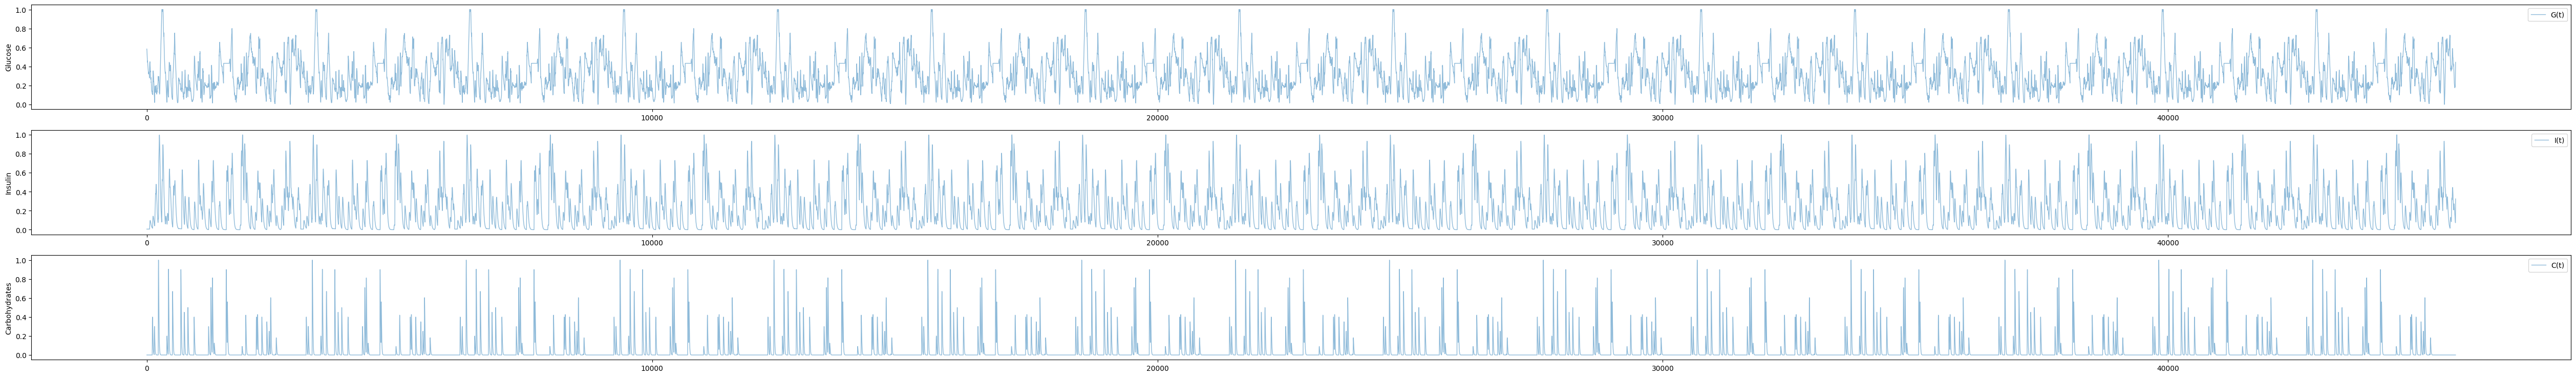

Train Set Size: 2046
Test Set Size: 1000
train_X: 2046 samples & 45 features
test_X: 1000 samples & 45 features

Reshaping train_X and test_X to add the timestep...
train_X shape: (2046, 1, 45) train_y shape: (2046,) 
test_X shape: (1000, 1, 45) test_y shape: (1000,) 

Epoch 1/30
13/13 - 4s - loss: 0.1545 - val_loss: 0.1622 - 4s/epoch - 311ms/step
Epoch 2/30
13/13 - 0s - loss: 0.1080 - val_loss: 0.1221 - 151ms/epoch - 12ms/step
Epoch 3/30
13/13 - 0s - loss: 0.0908 - val_loss: 0.1045 - 144ms/epoch - 11ms/step
Epoch 4/30
13/13 - 0s - loss: 0.0852 - val_loss: 0.1026 - 119ms/epoch - 9ms/step
Epoch 5/30
13/13 - 0s - loss: 0.0823 - val_loss: 0.0979 - 105ms/epoch - 8ms/step
Epoch 6/30
13/13 - 0s - loss: 0.0761 - val_loss: 0.0900 - 95ms/epoch - 7ms/step
Epoch 7/30
13/13 - 0s - loss: 0.0771 - val_loss: 0.0887 - 93ms/epoch - 7ms/step
Epoch 8/30
13/13 - 0s - loss: 0.0701 - val_loss: 0.0818 - 90ms/epoch - 7ms/step
Epoch 9/30
13/13 - 0s - loss: 0.0695 - val_loss: 0.0797 - 95ms/epoch - 7ms/step
Epoc

<Figure size 640x480 with 0 Axes>

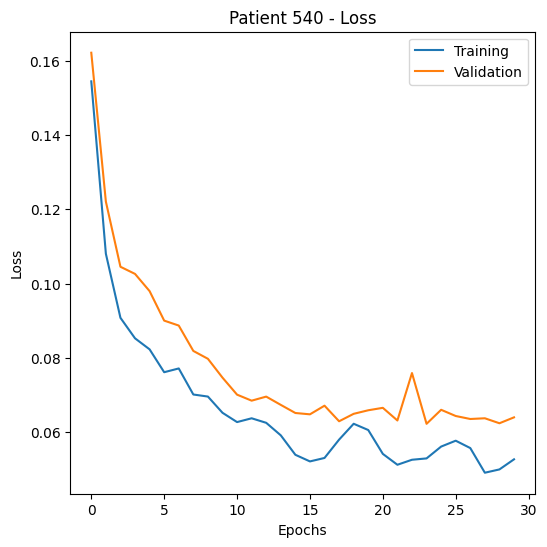

32/32 [==============================] - 1s 3ms/step


<Figure size 640x480 with 0 Axes>

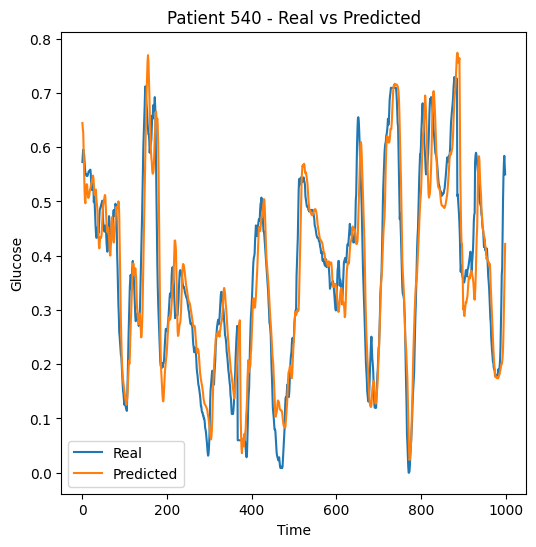

Clarke error grid zones
[0.896, 0.081, 0.0, 0.023, 0.0]


<Figure size 640x480 with 0 Axes>

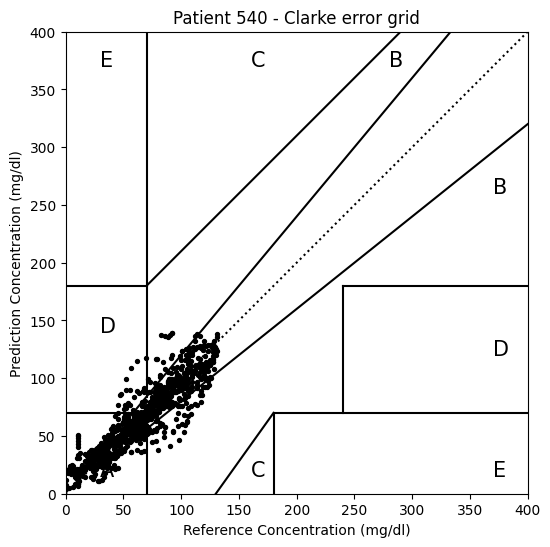

----------------------------------------------------------------------------------------------------
					Patient 544
----------------------------------------------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

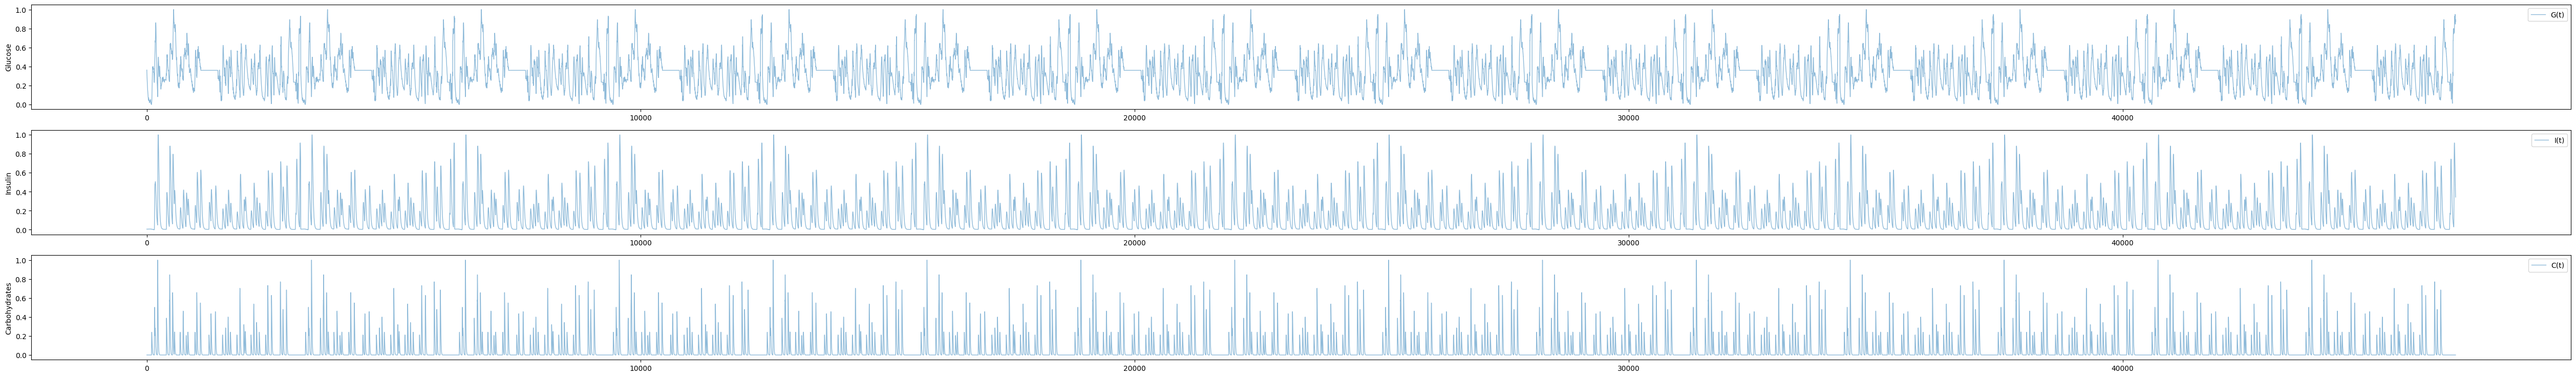

Train Set Size: 2116
Test Set Size: 1000
train_X: 2116 samples & 45 features
test_X: 1000 samples & 45 features

Reshaping train_X and test_X to add the timestep...
train_X shape: (2116, 1, 45) train_y shape: (2116,) 
test_X shape: (1000, 1, 45) test_y shape: (1000,) 

Epoch 1/30
14/14 - 4s - loss: 0.1799 - val_loss: 0.1464 - 4s/epoch - 298ms/step
Epoch 2/30
14/14 - 0s - loss: 0.0972 - val_loss: 0.0787 - 145ms/epoch - 10ms/step
Epoch 3/30
14/14 - 0s - loss: 0.0818 - val_loss: 0.0987 - 166ms/epoch - 12ms/step
Epoch 4/30
14/14 - 0s - loss: 0.0726 - val_loss: 0.0814 - 184ms/epoch - 13ms/step
Epoch 5/30
14/14 - 0s - loss: 0.0681 - val_loss: 0.0855 - 145ms/epoch - 10ms/step
Epoch 6/30
14/14 - 0s - loss: 0.0661 - val_loss: 0.0765 - 117ms/epoch - 8ms/step
Epoch 7/30
14/14 - 0s - loss: 0.0619 - val_loss: 0.0794 - 129ms/epoch - 9ms/step
Epoch 8/30
14/14 - 0s - loss: 0.0605 - val_loss: 0.0762 - 134ms/epoch - 10ms/step
Epoch 9/30
14/14 - 0s - loss: 0.0581 - val_loss: 0.0721 - 128ms/epoch - 9ms/st

<Figure size 640x480 with 0 Axes>

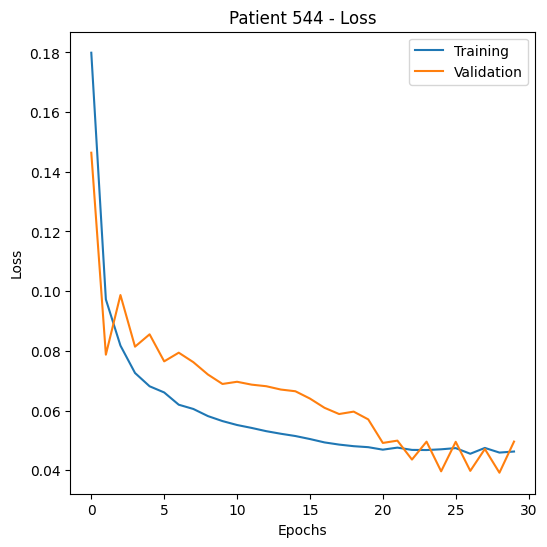

32/32 [==============================] - 1s 2ms/step


<Figure size 640x480 with 0 Axes>

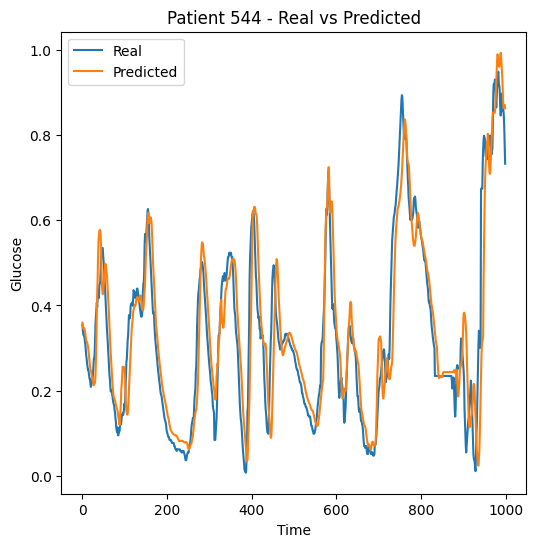

Clarke error grid zones
[0.878, 0.076, 0.0, 0.046, 0.0]


<Figure size 640x480 with 0 Axes>

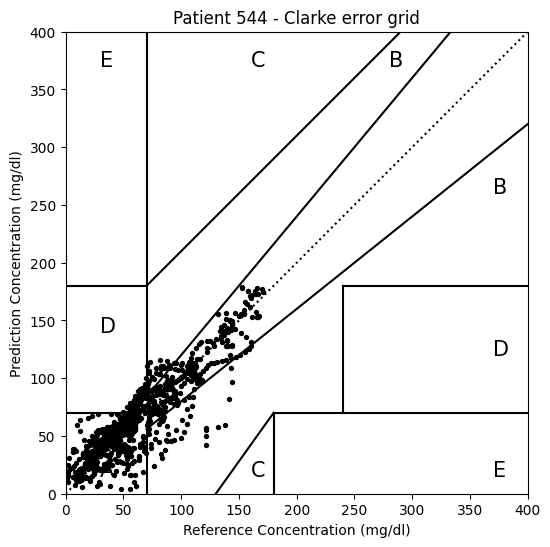

----------------------------------------------------------------------------------------------------
					Patient 552
----------------------------------------------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

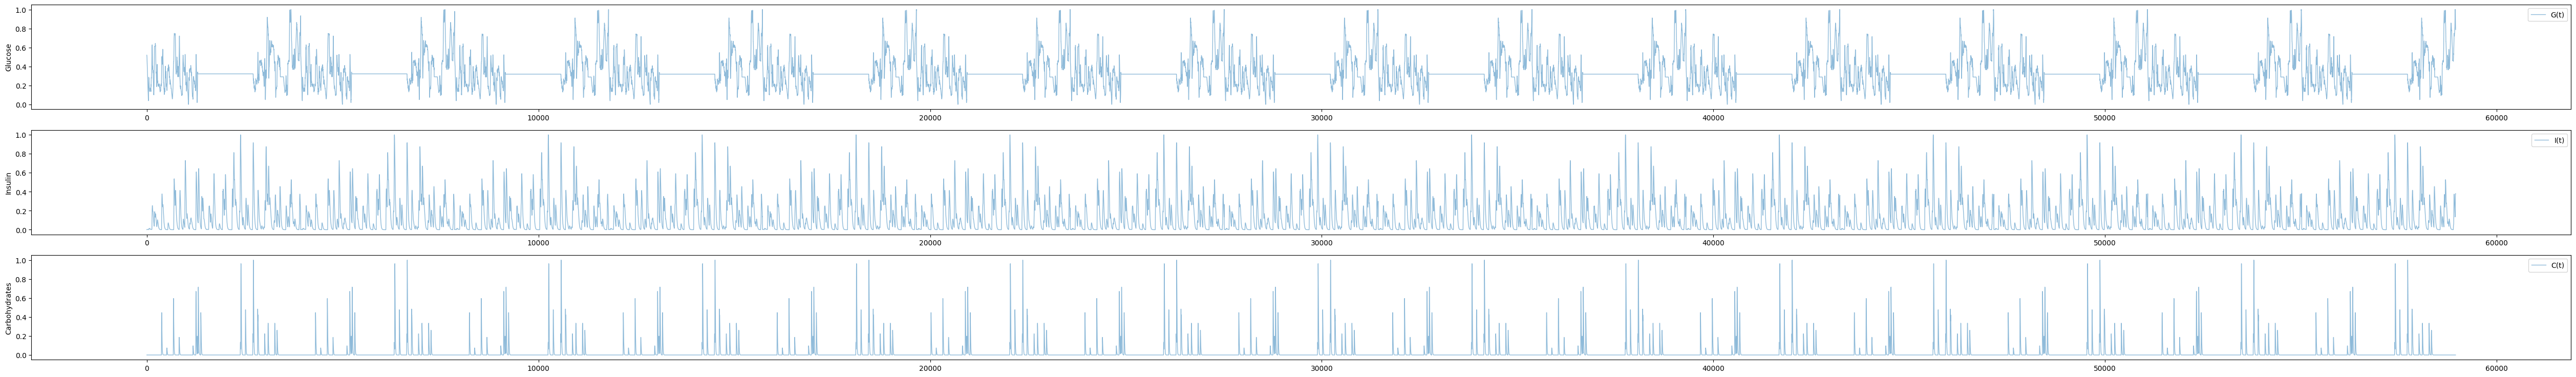

Train Set Size: 2930
Test Set Size: 1000
train_X: 2930 samples & 45 features
test_X: 1000 samples & 45 features

Reshaping train_X and test_X to add the timestep...
train_X shape: (2930, 1, 45) train_y shape: (2930,) 
test_X shape: (1000, 1, 45) test_y shape: (1000,) 

Epoch 1/30
19/19 - 4s - loss: 0.1423 - val_loss: 0.0648 - 4s/epoch - 189ms/step
Epoch 2/30
19/19 - 0s - loss: 0.0766 - val_loss: 0.0658 - 144ms/epoch - 8ms/step
Epoch 3/30
19/19 - 0s - loss: 0.0740 - val_loss: 0.0357 - 167ms/epoch - 9ms/step
Epoch 4/30
19/19 - 0s - loss: 0.0625 - val_loss: 0.0319 - 141ms/epoch - 7ms/step
Epoch 5/30
19/19 - 0s - loss: 0.0645 - val_loss: 0.0263 - 187ms/epoch - 10ms/step
Epoch 6/30
19/19 - 0s - loss: 0.0573 - val_loss: 0.0288 - 143ms/epoch - 8ms/step
Epoch 7/30
19/19 - 0s - loss: 0.0550 - val_loss: 0.0286 - 161ms/epoch - 8ms/step
Epoch 8/30
19/19 - 0s - loss: 0.0591 - val_loss: 0.0538 - 142ms/epoch - 7ms/step
Epoch 9/30
19/19 - 0s - loss: 0.0582 - val_loss: 0.0387 - 176ms/epoch - 9ms/step
E

<Figure size 640x480 with 0 Axes>

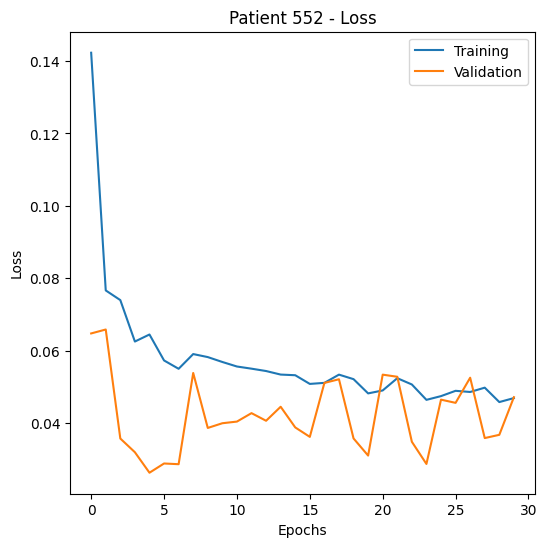

32/32 [==============================] - 1s 3ms/step


<Figure size 640x480 with 0 Axes>

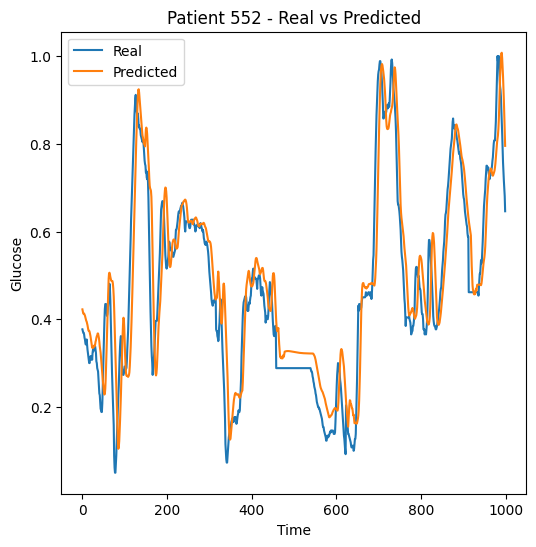

Clarke error grid zones
[0.827, 0.125, 0.0, 0.048, 0.0]


<Figure size 640x480 with 0 Axes>

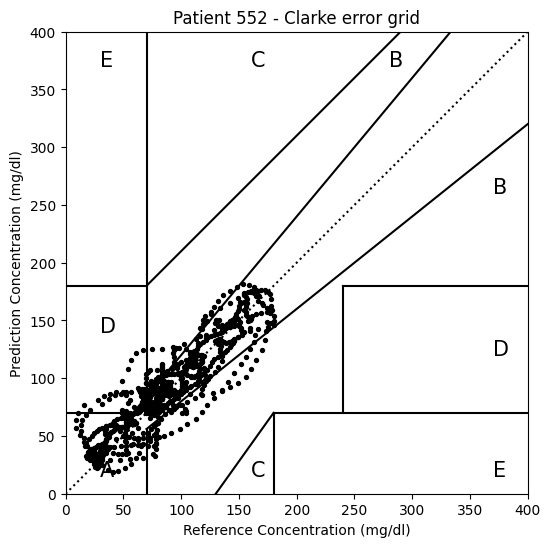

----------------------------------------------------------------------------------------------------
					Patient 559
----------------------------------------------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

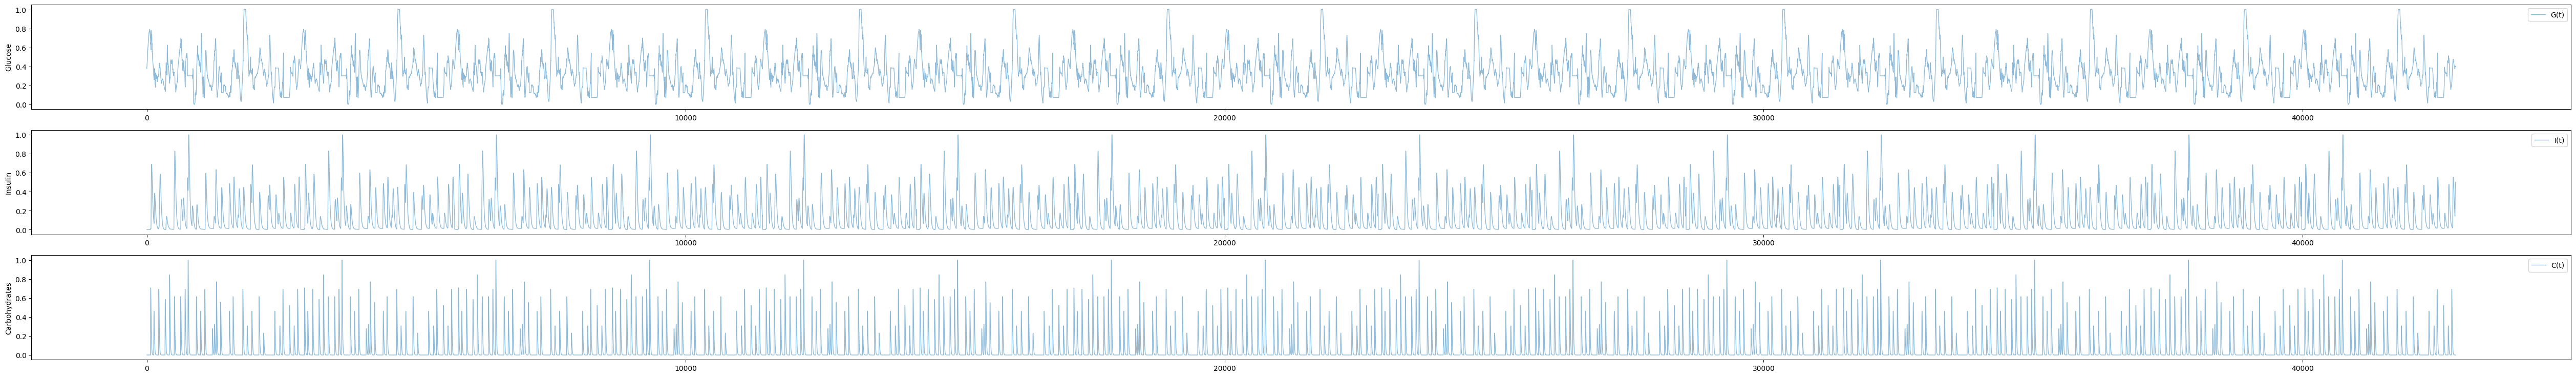

Train Set Size: 1856
Test Set Size: 1000
train_X: 1856 samples & 45 features
test_X: 1000 samples & 45 features

Reshaping train_X and test_X to add the timestep...
train_X shape: (1856, 1, 45) train_y shape: (1856,) 
test_X shape: (1000, 1, 45) test_y shape: (1000,) 

Epoch 1/30
12/12 - 4s - loss: 0.2609 - val_loss: 0.1419 - 4s/epoch - 342ms/step
Epoch 2/30
12/12 - 0s - loss: 0.1096 - val_loss: 0.1115 - 117ms/epoch - 10ms/step
Epoch 3/30
12/12 - 0s - loss: 0.0771 - val_loss: 0.1045 - 116ms/epoch - 10ms/step
Epoch 4/30
12/12 - 0s - loss: 0.0699 - val_loss: 0.0753 - 115ms/epoch - 10ms/step
Epoch 5/30
12/12 - 0s - loss: 0.0649 - val_loss: 0.0758 - 134ms/epoch - 11ms/step
Epoch 6/30
12/12 - 0s - loss: 0.0627 - val_loss: 0.0723 - 157ms/epoch - 13ms/step
Epoch 7/30
12/12 - 0s - loss: 0.0619 - val_loss: 0.0674 - 181ms/epoch - 15ms/step
Epoch 8/30
12/12 - 0s - loss: 0.0608 - val_loss: 0.0670 - 104ms/epoch - 9ms/step
Epoch 9/30
12/12 - 0s - loss: 0.0593 - val_loss: 0.0654 - 152ms/epoch - 13ms/

<Figure size 640x480 with 0 Axes>

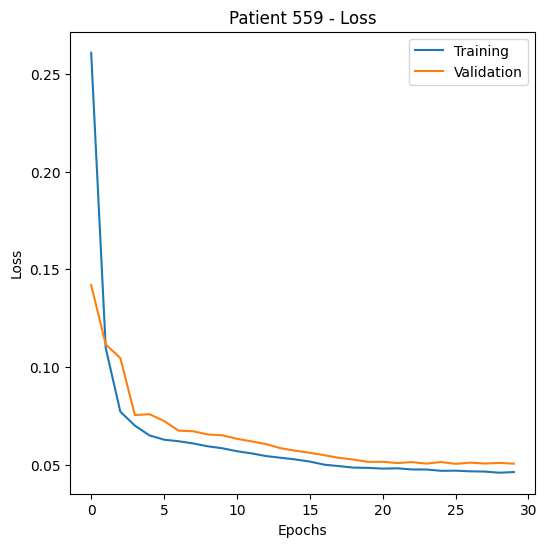

32/32 [==============================] - 1s 3ms/step


<Figure size 640x480 with 0 Axes>

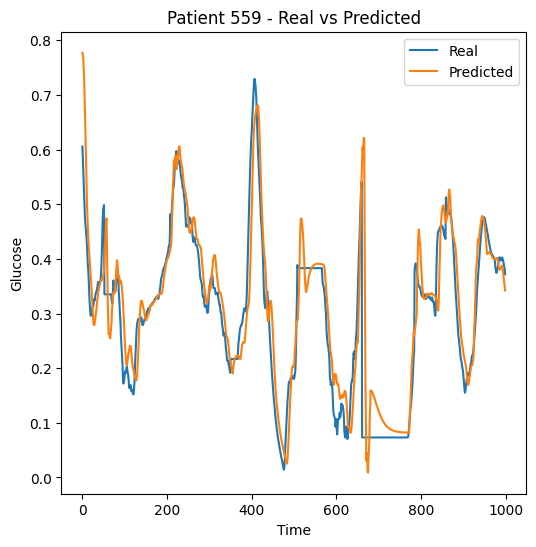

Clarke error grid zones
[0.932, 0.035, 0.0, 0.033, 0.0]


<Figure size 640x480 with 0 Axes>

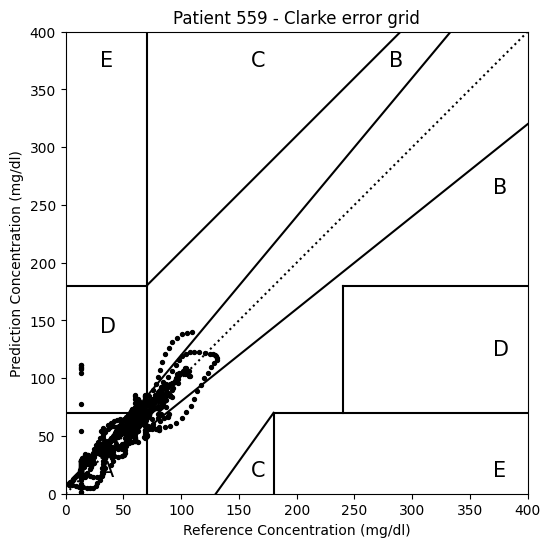

----------------------------------------------------------------------------------------------------
					Patient 563
----------------------------------------------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

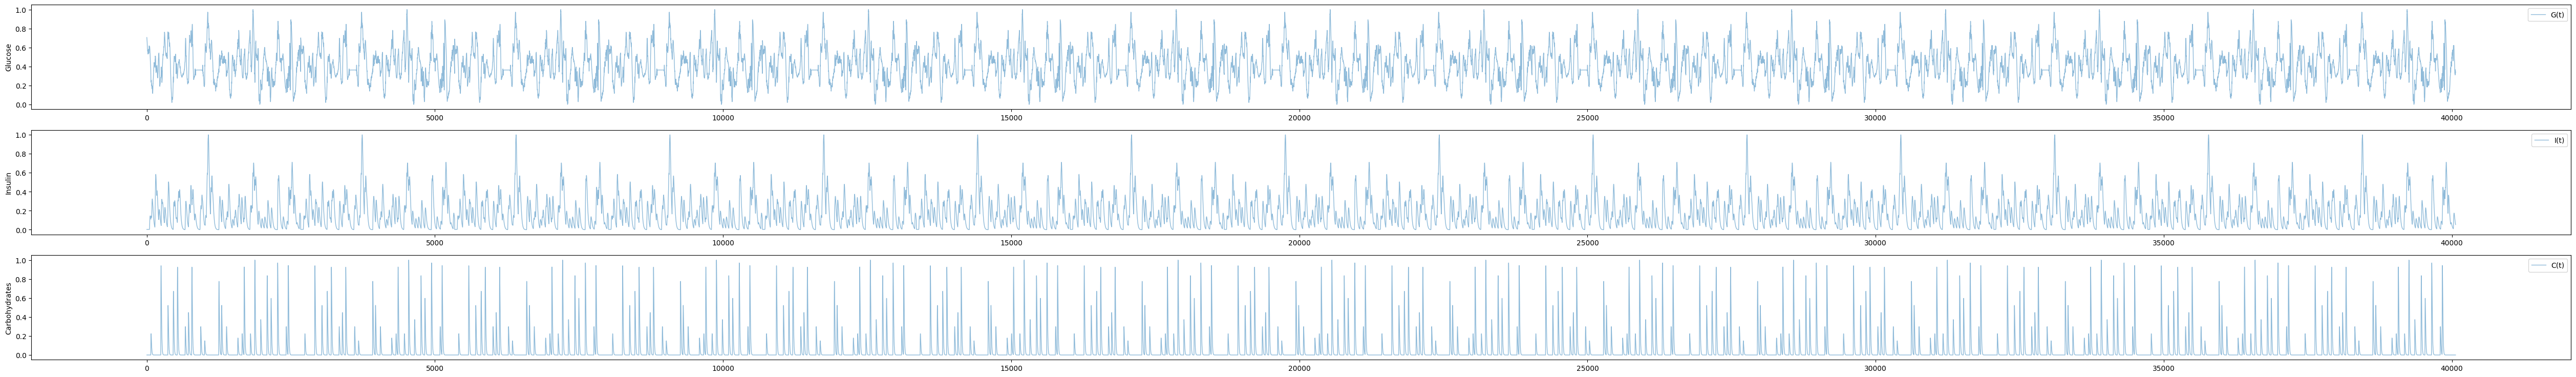

Train Set Size: 1671
Test Set Size: 1000
train_X: 1671 samples & 45 features
test_X: 1000 samples & 45 features

Reshaping train_X and test_X to add the timestep...
train_X shape: (1671, 1, 45) train_y shape: (1671,) 
test_X shape: (1000, 1, 45) test_y shape: (1000,) 

Epoch 1/30
11/11 - 3s - loss: 0.1877 - val_loss: 0.1041 - 3s/epoch - 316ms/step
Epoch 2/30
11/11 - 0s - loss: 0.0986 - val_loss: 0.0882 - 133ms/epoch - 12ms/step
Epoch 3/30
11/11 - 0s - loss: 0.0810 - val_loss: 0.0870 - 120ms/epoch - 11ms/step
Epoch 4/30
11/11 - 0s - loss: 0.0747 - val_loss: 0.0788 - 110ms/epoch - 10ms/step
Epoch 5/30
11/11 - 0s - loss: 0.0694 - val_loss: 0.0813 - 103ms/epoch - 9ms/step
Epoch 6/30
11/11 - 0s - loss: 0.0666 - val_loss: 0.0792 - 126ms/epoch - 11ms/step
Epoch 7/30
11/11 - 0s - loss: 0.0654 - val_loss: 0.0775 - 128ms/epoch - 12ms/step
Epoch 8/30
11/11 - 0s - loss: 0.0634 - val_loss: 0.0766 - 107ms/epoch - 10ms/step
Epoch 9/30
11/11 - 0s - loss: 0.0618 - val_loss: 0.0755 - 121ms/epoch - 11ms/

<Figure size 640x480 with 0 Axes>

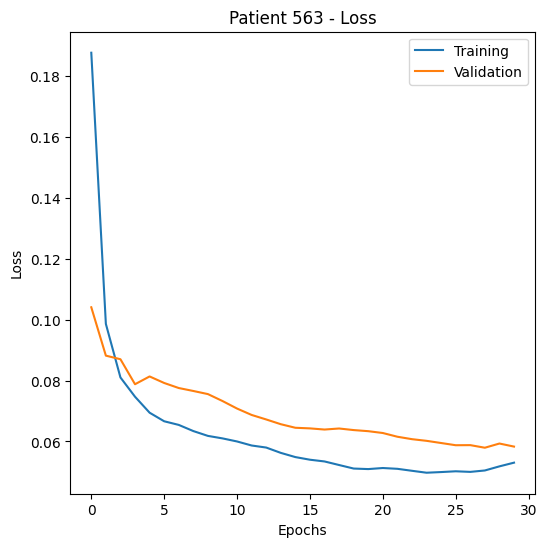

32/32 [==============================] - 1s 2ms/step


<Figure size 640x480 with 0 Axes>

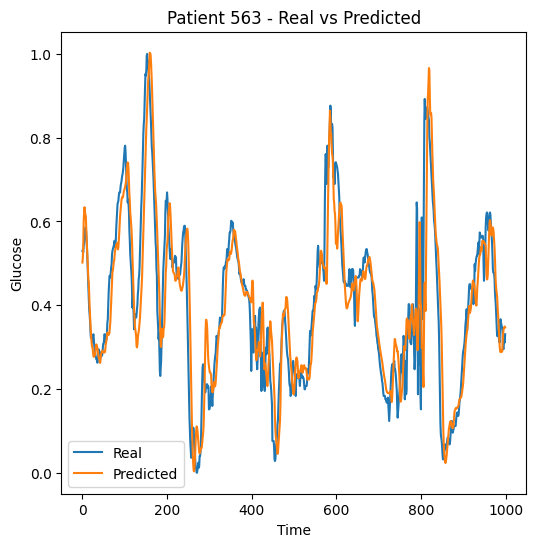

Clarke error grid zones
[0.857, 0.101, 0.0, 0.042, 0.0]


<Figure size 640x480 with 0 Axes>

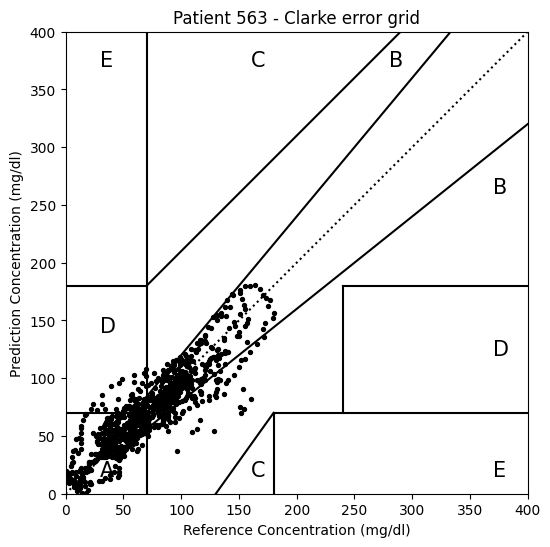

----------------------------------------------------------------------------------------------------
					Patient 567
----------------------------------------------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

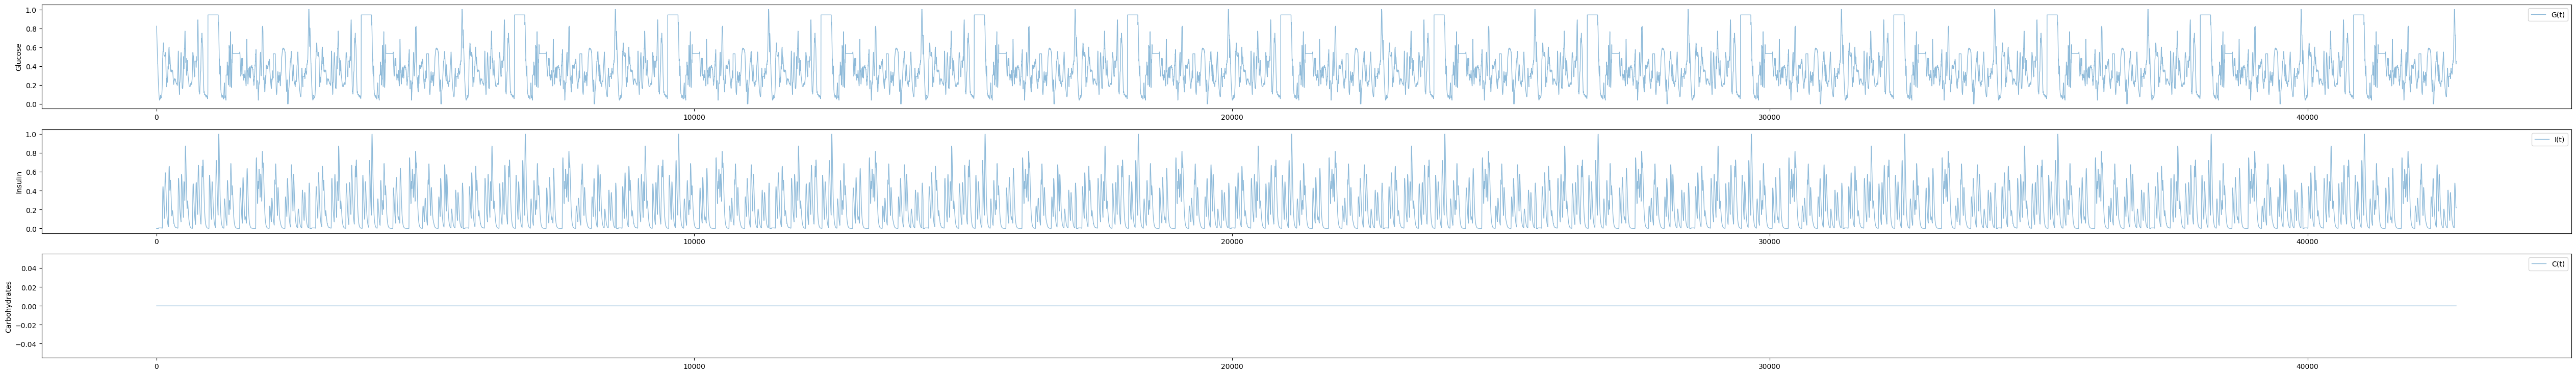

Train Set Size: 1851
Test Set Size: 1000
train_X: 1851 samples & 45 features
test_X: 1000 samples & 45 features

Reshaping train_X and test_X to add the timestep...
train_X shape: (1851, 1, 45) train_y shape: (1851,) 
test_X shape: (1000, 1, 45) test_y shape: (1000,) 

Epoch 1/30
12/12 - 4s - loss: 0.1957 - val_loss: 0.1364 - 4s/epoch - 316ms/step
Epoch 2/30
12/12 - 0s - loss: 0.1509 - val_loss: 0.0783 - 165ms/epoch - 14ms/step
Epoch 3/30
12/12 - 0s - loss: 0.0984 - val_loss: 0.0714 - 100ms/epoch - 8ms/step
Epoch 4/30
12/12 - 0s - loss: 0.0898 - val_loss: 0.0692 - 110ms/epoch - 9ms/step
Epoch 5/30
12/12 - 0s - loss: 0.0869 - val_loss: 0.0627 - 106ms/epoch - 9ms/step
Epoch 6/30
12/12 - 0s - loss: 0.0884 - val_loss: 0.0672 - 101ms/epoch - 8ms/step
Epoch 7/30
12/12 - 0s - loss: 0.0833 - val_loss: 0.0683 - 102ms/epoch - 9ms/step
Epoch 8/30
12/12 - 0s - loss: 0.0868 - val_loss: 0.0852 - 103ms/epoch - 9ms/step
Epoch 9/30
12/12 - 0s - loss: 0.0850 - val_loss: 0.0592 - 96ms/epoch - 8ms/step
Ep

<Figure size 640x480 with 0 Axes>

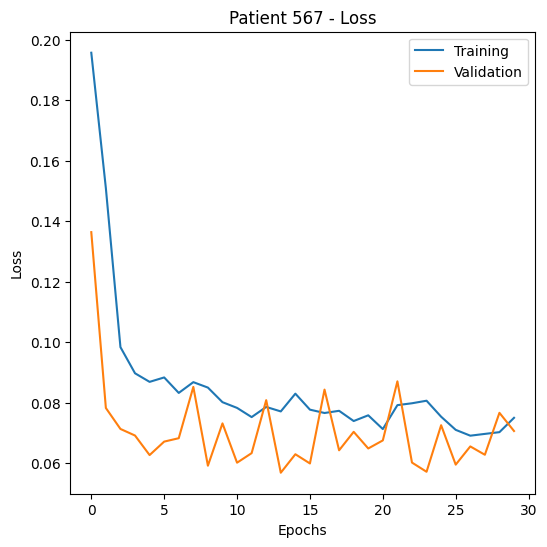

32/32 [==============================] - 1s 3ms/step


<Figure size 640x480 with 0 Axes>

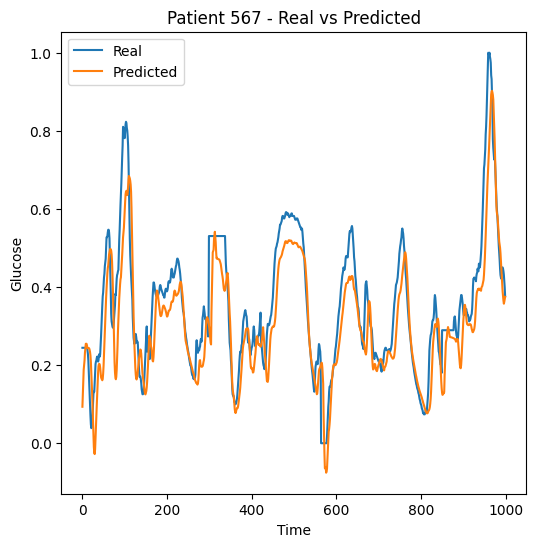

Input Warning: the minimum reference value 0.0 or the minimum prediction value -13.600138127803802 is less than 0 mg/dl.
Clarke error grid zones
[0.858, 0.133, 0.0, 0.009, 0.0]


<Figure size 640x480 with 0 Axes>

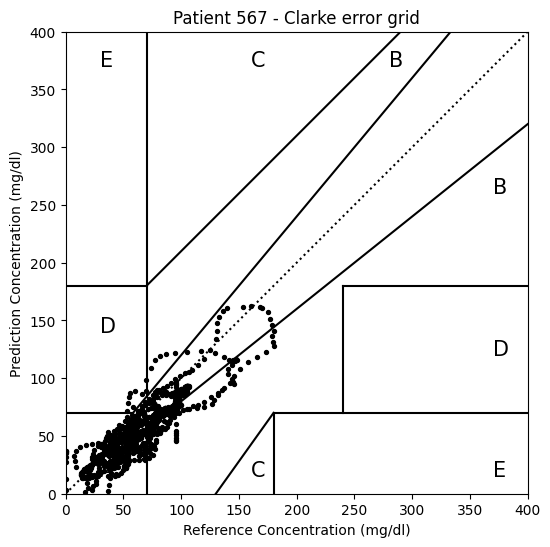

In [18]:
'''
This is the main function that starts the pipeline
'''
def main():
    seed(819)
    set_seed(819)

    initial_path = 'Datasets'
    ids_csvs = get_ids_csvs(initial_path)

    # Obtain the mae for each patient of the ids_csvs dictionary (executing the pipeline for each patient)
    for patient in sorted(ids_csvs):
        print('-------------------------------------------------------------------------------------------'
              f'---------\n\t\t\t\t\tPatient {patient}\n--------------------------------------------------'
              '--------------------------------------------------')
        dataset = load_data(f'{initial_path}/{patient}/{ids_csvs[patient]}', patient)
        real, predicted = model_manipulation(dataset, patient)
        mae, mse, rmse = metrics_evaluation(real, predicted)
        globals()[f'mae{patient}'] = mae # for the pipeline_metrics we use only the mae

if __name__ == '__main__':
    main()

### Metrics

In [19]:
print(mae540)
print(mae544)
print(mae552)
print(mae559)
print(mae563)
print(mae567)

0.05468772718946184
0.06448151779097834
0.07214255088141454
0.04264195965468344
0.06812041126763864
0.06909066854711236
